# $\large Atomic\space Collisions\space and\space Thermodynamic\space Equilibrium$


## 1. Introduction

This project studies the thermal model of N-particles system in an isolated square box of length L. Particles are assumed to be spheres of radius R.

Each collision is elastic in nature, particles move in a straight line untill a collision.

To determine the final velocities after collisions we use these equations:

\begin{aligned}\mathbf {v} '_{1}&=\mathbf {v} _{1}-{\frac {2m_{2}}{m_{1}+m_{2}}}\ {\frac {\langle \mathbf {v} _{1}-\mathbf {v} _{2},\,\mathbf {x} _{1}-\mathbf {x} _{2}\rangle }{\|\mathbf {x} _{1}-\mathbf {x} _{2}\|^{2}}}\ (\mathbf {x} _{1}-\mathbf {x} _{2}),\\\mathbf {v} '_{2}&=\mathbf {v} _{2}-{\frac {2m_{1}}{m_{1}+m_{2}}}\ {\frac {\langle \mathbf {v} _{2}-\mathbf {v} _{1},\,\mathbf {x} _{2}-\mathbf {x} _{1}\rangle }{\|\mathbf {x} _{2}-\mathbf {x} _{1}\|^{2}}}\ (\mathbf {x} _{2}-\mathbf {x} _{1})\end{aligned}

                                     where the angle brackets indicate dot products
                                     
                                     
This system can also be considered analogous to an ideal gas as there are no intramolecular forces. All collisions are elastic and we will also see the brownian motion of the gas later. 

## 2. Description of Algorithms

1. Simulation takes a list of Particles with intial positions and velocties


2. We check that no particle intially overlaps


3. Check if each particle collides with the wall or any other particle


4. The particle is then advanced in time by dt. Repeat Step 3


### Initialization of the system

The velocity distribution of the particles are specified by the temperature, which is proportional to the average kinetic energy of particles: 
$$ \dfrac{1}{2}m \bar v^2 = n kT $$
For simplicity, we set nk=1 here. Then the average velocity is calculated by:
$$ \bar v = \sqrt {\dfrac{2T}{m}} $$
To initialize of multiple partilce system, we do sampling from 2-D Maxwell-Boltzman velocity distribution:
$$ f(v_{x},v_{y}) =  \dfrac{m}{2 \pi T} exp[{-\dfrac{m(v_x^2 + v_y^2)}{2T}}] $$
The expectation value is zero and the standard deviation $\sigma$ of both $v_x$ and $v_y$ is $\sqrt{\dfrac{T}{m}}$

In [2]:
class Particle():
    """This class describes the motion of N particles in a 2D square box with length L

    Data Attributes:
        T: The initial temperature, for simplicity, let the Boltzman constant to be 1
        L: The length of the square box (m)
        M_: The constant property of particles, in the form of: [[m1, R1], [m2, R2],.....]
        p0: The initial state of the N particles, they are expressed in one phase vector of the form:
            array([[x1, y1, vx1, vy1], ...])   (4*N-dimensional)

    Methods:
        __init__
        evolve
        visualize
    """
    
    def __init__(self, temp, L, N_, M_, p_self=None, M_self=None):
        '''Initialize a N-particle system
        temp: The temperature of the system, the dimension of it here is normalized to the average kinetic energy of particles
        L: length of the square box, an intnumber for pure particles or a list for mixed particles
        N_: an int number for pure particles or a list for mixed particles
        M_: a list for pure particle or a nested list for mixed particles
        '''
        
        # Sampling from Maxwell distribution
        if p_self is None:
            # single type of particle case
            if isinstance(N_, int):
                self.temp = temp
                self.N = N_
                self.L = L
                self.M = []
                
                #Mass and radius
                for i in range(0,N_):
                    self.M.append(M_)
                
                x = np.random.uniform(0, L, size=[N_, 2])
                sigma = np.sqrt(temp/M_[0])
                vx = np.random.normal(loc=0, scale=3*sigma, size=N_)
                vy = np.random.normal(loc=0, scale=3*sigma, size=N_)
                
                angle = np.random.uniform(0, 2*np.pi, size=N_)
                vx = vx * np.cos(angle)
                vy = vy * np.sin(angle)
                
                v = np.dstack((vx,vy))
                p = np.concatenate((x,v[0]), axis=1)
                self.p0 = np.around(p, decimals=3)
            
            # multiple type of particle case
            elif isinstance(N_, list):
                self.temp = temp
                self.N = N_.sum()
                self.L = L
                p_ = np.array([])
                # distribute mass, radius, position and velocity for each particle corresponding to their phase vector
                M_lst = []
                
                for i in range(0, N_):
                        
                    x = np.random.uniform(0, L, size=[N_[i], 2])
                    sigma = np.sqrt(temp/M_[i][0])
                    vx = np.random.normal(loc=0, scale=3*sigma, size=N_[i])
                    vy = np.random.normal(loc=0, scale=3*sigma, size=N_[i])
                        
                    angle = np.random.uniform(0, 2*np.pi, size=N_[i])
                    vx = vx * np.cos(angle)
                    vy = vy * np.sin(angle)
                        
                    v = np.dstack((vx,vy))
                    p = np.concatenate((x,v[0]), axis=1)
                    
                    p_ = np.concatenate((p_,p), axix=0)
                    
                    for j in range(0, N_[i]):
                        M_lst.append(M_[i])
                        
                self.M = M_lst
                self.p0 = p_
                
                
                
        # This case is for convenient setting of the initialization
        else: 
            self.temp = temp
            self.N = len(p_self)
            self.L = L
            self.M = M_self
            self.p0 = p_self
        
    
    def collision_w(self, p):
        '''Collision between particles and the wall'''
        p_lst = []
        
        for i in range(0 , self.N):
            if abs(p[i][0] - 0) <= self.M[i][1] or abs(p[i][0] - self.L) <= self.M[i][1]:
                vx = -p[i][2]
            else:
                vx = p[i][2]
            if abs(p[i][1] - 0) <= self.M[i][1] or abs(p[i][1] - self.L) <= self.M[i][1]:
                vy = -p[i][3]
            else:
                vy = p[i][3]
                    
            p_lst.append([p[i][0], p[i][1], vx, vy])
            i-=1
        return p_lst
    
    def single_collide(self, p, i, j):
        """collision between two particles"""
        m1 = self.M[i][0]
        m2 = self.M[j][0]
        M = m1 + m2
        
        vx1 = p[i][2]
        vy1 = p[i][3]
        vx2 = p[j][2]
        vy2 = p[j][3]
        
        v1 = np.array([vx1, vy1])
        v2 = np.array([vx2, vy2])
        
        x1 = p[i][0]
        y1 = p[i][1]
        x2 = p[j][0]
        y2 = p[j][1]
        
        r1 = np.array([x1, y1])
        r2 = np.array([x2, y2])
        normal = np.linalg.norm(r1 - r2)**2
        
        final_v1 = v1 - ((2*m2 / M) * (np.dot(v1-v2, r1-r2) / normal) * (r1 - r2))
        final_v2 = v2 - ((2*m1 / M) * (np.dot(v2-v1, r2-r1) / normal) * (r2 - r1))

        p[i][2] = final_v1[0] 
        p[i][3] = final_v1[1]
        p[j][2] = final_v2[0]
        p[j][3] = final_v2[1]
    
    def collision_p(self, p):
        """
        Two particles p1 and p2 have collided elastically: update their
        velocities.
        """
        p_ = p
        for i in range(0, self.N):
            if i < self.N -1:
                for j in range(i+1, self.N):
                    if (p_[i][0]-p_[j][0])**2 + (p_[i][1] - p_[j][1])**2 <= (self.M[i][1] + self.M[j][1])**2:
                        self.single_collide(p_, i, j)
        
    def evolve(self, time, dt=0.01):
        '''This function runs the time evolution of the system
           time: the total evoluiton time
           dt: The timestep of evolution
        '''
        time_lst = np.linspace(0, time, time/dt)
        p = self.p0
        
        for t_p in time_lst:
            
            # Perform the wall-particle collision
            p_lst = self.collision_w(p)
            
            # Perform the particle-particle collision
            self.collision_p(p_lst)
            p_lst2 = []
            # Run the motion of the N-particle system
            for pi in p_lst:
                dpdt = np.array([pi[2], pi[3], 0, 0])
                dp = pi + dpdt*dt
                p_lst2.append(dp)
            
            p = np.array(p_lst2)
            
        return np.around(p, decimals=3)
    
    def get_energy(self, show='No'):
        """Calculate the average energy of the particle system and compare it with temperature"""
        v = self.p0[:,2:]
        m = np.array(self.M)[:,1:]
        E =( v**2 *np.concatenate((m,m),axis=1)).sum()
        ave_E = E/self.N
        
        if show=='Yes':
            if abs(ave_E - self.temp)/self.temp <= 0.03:
                print('The average energy of the system is conserved')
            else:
                print('The average energy of the system is not conserved')
        print('The energy is:')        
        return ave_E
    
    def speed_dis(self):
        '''Calculate the speed distribution'''
        v=self.p0[:,2:]
        
        vx = v[:,0:1]
        vy = v[:,1:]
        
        speed = np.sqrt(vx**2 + vy**2)

        #n, bins, patches = plt.hist(x, 20, density=1, facecolor='blue', alpha=0.75)  #第二个参数是直方图柱子的数量
        mu =np.mean(speed)
        sigma =np.std(speed) 
        num_bins = 50
        n, bins, patches = plt.hist(speed, num_bins,density=1, alpha=0.75)  
        y = norm.pdf(bins, mu, sigma)
        
        plt.plot(bins, y, 'r--')
        plt.title('The speed distribution of particles')
        plt.xlabel('Speed')
        plt.ylabel('f(v)')
        plt.show()


### Tests:

#### Test1: Conservation of Energy and Momentum

We take two particles and calculate their intial kinetic energy and momentum and then after collision we calculate their final kinetic energy and momentum for the following case

1. Two particles, one at rest, colliding at an angle.
2. Two particles in head on collision.

In [3]:
single_x1 = Particle(temp=2, L=1.1, N_=2, M_=[[10**-6, 0.1], [10**-6, 0.1]], \
                  p_self=np.array([[0.2, 0.1, 0.05, 0], [0.5, 0.1, -0.05, 0]]), M_self=[[10**-6, 0.1], [10**-6, 0.1]])
single_x1.evolve(2, dt=0.01)

array([[ 0.2 ,  0.1 , -0.05,  0.  ],
       [ 0.5 ,  0.1 ,  0.05,  0.  ]])

##### Note:
This result means the two balls at (0.2, 0.1) and (0.5, 0,1) collides at t=1 and exchange their velocity. This implies the particle-particle collision in x-direction part of the code works fine. 

In [4]:
single_y1 = Particle(temp=2, L=1.1, N_=2, M_=[[10**-6, 0.1], [10**-6, 0.1]], \
                  p_self=np.array([[0.1, 0.2, 0, 0.05], [0.1, 0.5, 0, -0.05]]), M_self=[[10**-6, 0.1], [10**-6, 0.1]])
single_y1.evolve(2, dt=0.01)

array([[ 0.1 ,  0.2 ,  0.  , -0.05],
       [ 0.1 ,  0.5 ,  0.  ,  0.05]])

Similarly, the particle-particle collision in y-direction part of the code works fine. This test is a simple but only for compatible with Junzhe's code. For visualization, the Makuyh's version is more vivid. 

#### Test2: Collision with Walls

We take a single particle and let it go on in a small box with a speed fast enough to have multiple collisions with different walls 

In [5]:
single_x2 = Particle(temp=2, L=1.1, N_=2, M_=[[10**-6, 0.1], [10**-6, 0.1]], \
                  p_self=np.array([[0.2, 0.1, -0.1, 0], [0.9, 0.1, 0.1, 0]]), M_self=[[10**-6, 0.1], [10**-6, 0.1]])
single_x2.evolve(2, dt=0.0001)

array([[ 0.2,  0.1,  0.1,  0. ],
       [ 0.9,  0.1, -0.1,  0. ]])

##### Note:
This case is the simplest test for particle-wall collision in x-direction. The initial positions of two particles are (0.2, 0.1), (0.9, 0.1) respectively, and moves towards the opposite direction. The result is what we expect. The two balls are bounced and the vx are reversed. Similar for y-direction test:

In [6]:
single_y2 = Particle(temp=2, L=1.1, N_=2, M_=[[10**-6, 0.1], [10**-6, 0.1]], \
                  p_self=np.array([[0.1, 0.2, 0, -0.1], [0.1, 0.9, 0, 0.1]]), M_self=[[10**-6, 0.1], [10**-6, 0.1]])
single_y2.evolve(2, dt=0.0001)

array([[ 0.1,  0.2,  0. ,  0.1],
       [ 0.1,  0.9,  0. , -0.1]])

#### Test3: Velocity distribution after collisions

We take n particles and put them in a block with random positions and velocities and let them simulate and after equilibrium is achieved we plot the velocities 

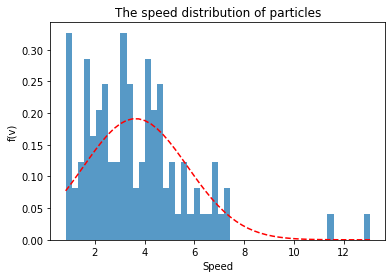

In [7]:
System_1 = Particle(temp=2, L=100, N_=100, M_=[1, 0.2])
v_1 = System_1.p0[:,2:]
System_1.speed_dis()

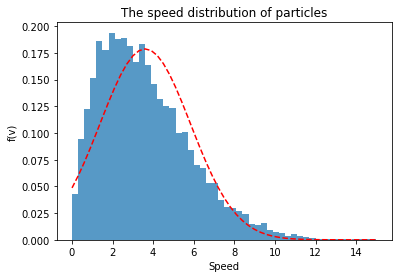

In [8]:
System_2 = Particle(temp=2, L=100, N_=10000, M_=[1, 0.001])
v_2 = System_2.p0[:,2:]
System_2.speed_dis()

## Second way to implement:

### Implementation

Simulation is implemented as a class and it takes in a list of particles which are classes on its own.

For simplicity mass is considered 1 unit for intial cases and velocity is between -1 and 1

Working of each test and study is then given before it

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [10]:
class Particle:
    """A class representing a particle which is approximated to be a sphere"""

    def __init__(self, x, y, vx, vy, Mass = 1, radius = 0.01):
        """Initialize the particle's position, velocity, and radius."""

        self.r = np.array((x, y))
        self.v = np.array((vx, vy))
        self.radius = radius
        self.mass = Mass
        
    
    def __str__(self):
        """Prints the particle"""
        
        s = "r: "+str(self.r[0])+','+str(self.r[1])+" v: "+str(self.v[0])+','+str(self.v[1])
        
        
        return s

    def x(self, value):
        """updates the x value of the particle"""
        self.r[0] = value
    def y(self, value):
        """updates the y value of the particle"""
        self.r[1] = value
    def vx(self, value):
        """updates the x velocity value of the particle"""
        self.v[0] = value
    def vy(self, value):
        """updates the y velocity value of the particle"""
        self.v[1] = value  

    def overlaper(self, other):
        """Checks if the two particles overlap"""
        x = (self.r - other.r) #distance between the two particles
        return np.hypot(*x) < self.radius + other.radius
    
    def momentum(self):
        return [self.v[0]*self.mass,self.v[1]*self.mass]


In [11]:
class Simulation:
    """
    A class for a simple particle simulation in a square box of length L.
    """

    def __init__(self, p, L=1, temp = 273, dt=0.01):
        """
        Initialize the simulation with 
        
        p: A list of particles
        
        L: length of box
        
        Temp: Temperature of the box
        
        dt: time step
        """

        self.p      = p
        self.box    = [0,L]
        self.temp   = temp
        self.dt     = dt
        self.output = []#the output
          

    

    def ode(self, p, dt):
        """Advance the Particle's position forward in time by dt."""
        #b = self.v * dt
        #np.add(self.r, b, out=self.r, casting="unsafe")
        p.r = p.r + (p.v * dt)
    
    def overlap_checker(self):
        """checks if the list of particles input by the user are overlapping"""
        
        for i in range(len(self.p)):
            
            if(i<len(self.p)-1):
                if(self.p[i].overlaper(self.p[i+1])):
                    return False
        
        return True
    
    def collison_v(self, x1, x2):
        """
        
        When particles x1 and x2 collide it updates the velocity after collision
        
        """
        m1 = x1.mass
        m2 = x2.mass
        M = m1 + m2
        r1 = x1.r
        r2 = x2.r
        normal = np.linalg.norm(r1 - r2)**2
        v1 = x1.v
        v2 = x2.v
        #using the equations to find the final velocities
        final_v_1 = v1 - ((2*m2 / M) * (np.dot(v1-v2, r1-r2) / normal) * (r1 - r2))
        final_v_2 = v2 - ((2*m1 / M) * (np.dot(v2-v1, r2-r1) / normal) * (r2 - r1))
        x1.v = final_v_1
        x2.v = final_v_2
        #print(x1)
        
    def walls(self, v):
        """Bounce the particles off the walls elastically."""
        a = self.box[0] + v.radius
        b = self.box[1] - v.radius
        
        #checks all 4 of the boundry conditions
        if v.r[0] - v.radius < self.box[0]:
            v.r[0] = a
            v.v[0] = -v.v[0]
        if v.r[0] + v.radius > self.box[1]:
            v.r[0] = b
            v.v[0] = -v.v[0]
        if v.r[1] - v.radius < self.box[0]:
            v.r[1] = a
            v.v[1] = (-v.v[1])
        if v.r[1] + v.radius > self.box[1]:
            v.r[1] = b
            v.v[1] = (-v.v[1])
            
            
    def do_simulate(self,time):
        """
        Simulates motion of n particles in a box for a given amount of time.
        
        
        
        """
        time_range = np.arange(0,time,self.dt)
        for i in time_range:
            lst = []
            for j in range(len(self.p)):
                #checks if the particle is colliding with walls
                self.walls(self.p[j])
                    
                if(j<len(self.p)-1):
                    #checks if the particle is colliding with another particle 
                    if(self.p[j].overlaper(self.p[j+1])):
                        self.collison_v(self.p[j],self.p[j+1])
                
                #advance the particle in time
                self.ode(self.p[j], self.dt)
                x2 = self.p[j].v*-1*-1 
                x3 = self.p[j].r 
                    
                lst.append([x3,x2])
            self.output.append(lst) 
        return self.output
        
            
   

### Tests:

#### Test1: Conservation of Energy and Momentum

We take two particles and calculate their intial kinetic energy and momentum and then after collision we calculate their final kinetic energy and momentum for the following case

1. Two particles, one at rest, colliding at an angle.
2. Two particles in head on collision.

Is momentum conserved: True
Is energy conserved: True


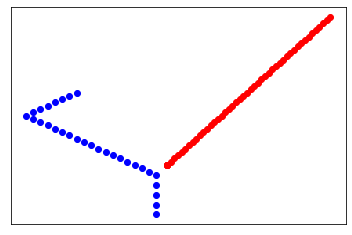

In [12]:
#checking for conservation of momentum and energies in a collision of two particles at an angle where one particle is at rest

#intialize the particles
par  = Particle(0.05,0.13,1,0)
par1 = Particle(0.11,0.14,0,0,Mass = 2)
par_lst = [par,par1]
sim = Simulation([par,par1])

#values are calculated
initial_momentum1 = np.sum([i.v*i.mass for i in par_lst])
initial_energy1 = np.sum([i.v*i.v*0.5*i.mass for i in par_lst])
final_momentum1 = np.sum([i[1]*j.mass for i in sim.do_simulate(.1)[-1] for j in par_lst])
final_energy_part = [0.5*i[1]*i[1] for i in sim.do_simulate(.1)[-1]]

#final kinetic energy is calculated
lst = []
for i in range(len(final_energy_part)):
    for j in final_energy_part[i]:
        lst.append(j*par_lst[i].mass)
final_energy1 = np.sum(lst)

#we check if momentum is conserved
conserve_momentum1 = abs(initial_momentum1-final_momentum1)<0.001
conserve_energy1 = abs(initial_energy1-final_energy1)<0.001


print("Is momentum conserved: " + str(conserve_momentum1))
print("Is energy conserved: " + str(conserve_energy1))

#graphs are ploted
output_1_x=[i[0][0][0] for i in sim.do_simulate(.1)][:30]
output_1_y=[i[0][0][1] for i in sim.do_simulate(.1)][:30]
output_2_x=[i[1][0][0] for i in sim.do_simulate(.1)][:50]
output_2_y=[i[1][0][1] for i in sim.do_simulate(.1)][:50]
plt.plot(output_1_y,output_1_x,'bo');
plt.plot(output_2_y,output_2_x,'ro');


plt.xticks([]);
plt.yticks([]);

Is momentum conserved: True
Is energy conserved: True


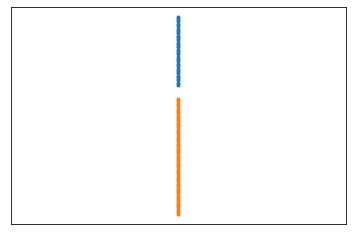

In [13]:
#checking for conservation of momentum and energies in a collision of two particles headon

#intialized the particles
par  = Particle(0.55,0.13,1,0)
par1 = Particle(0.51,0.13,-1,0)
par_lst = [par,par1]
sim = Simulation([par,par1])

#energy and momentum are calculated
initial_momentum1 = np.sum([i.v*i.mass for i in par_lst])
initial_energy1 = np.sum([i.v*i.v*0.5*i.mass for i in par_lst])
final_momentum1 = np.sum([i[1]*j.mass for i in sim.do_simulate(.1)[-1] for j in par_lst])
final_energy_part = [0.5*i[1]*i[1] for i in sim.do_simulate(.1)[-1]]

lst = []
for i in range(len(final_energy_part)):
    for j in final_energy_part[i]:
        lst.append(j*par_lst[i].mass)

final_energy1 = np.sum(lst)

#conservation is checked
conserve_momentum1 = abs(initial_momentum1-final_momentum1)<0.01
conserve_energy1 = abs(initial_energy1-final_energy1)<0.01


print("Is momentum conserved: " + str(conserve_momentum1))
print("Is energy conserved: " + str(conserve_energy1))

#graph for motion is plotted
output_1_x=[i[0][0][0] for i in sim.do_simulate(.1)][:30]
output_1_y=[i[0][0][1] for i in sim.do_simulate(.1)][:30]
output_2_x=[i[1][0][0] for i in sim.do_simulate(.1)][:50]
output_2_y=[i[1][0][1] for i in sim.do_simulate(.1)][:50]
plt.plot(output_1_y,output_1_x,'.');
plt.plot(output_2_y,output_2_x,'.');

plt.xticks([]);
plt.yticks([]);


#### Test2: Collision with Walls

We take a single particle and let it go on in a small box with a speed fast enough to have multiple collisions with different walls 

Is momentum conserved: True
Is energy conserved: True


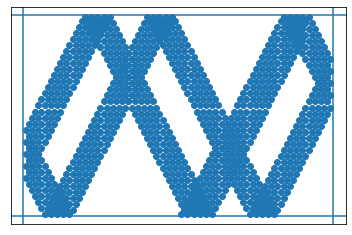

In [14]:
#multiple wall collisions

#values intialized
par2  = Particle(0,0.5,3,1)
par_lst = [par2]
sim = Simulation([par2])

#energies and momentums are calculated
initial_momentum1 = np.sum([i.v*i.mass for i in par_lst])
initial_energy1 = np.sum([i.v*i.v*0.5*i.mass for i in par_lst])
final_momentum1 = np.sum([i[1]*j.mass for i in sim.do_simulate(.1)[-1] for j in par_lst])
final_energy_part = [0.5*i[1]*i[1] for i in sim.do_simulate(.1)[-1]]

lst = []
for i in range(len(final_energy_part)):
    for j in final_energy_part[i]:
        lst.append(j*par_lst[i].mass)

final_energy1 = np.sum(lst)

#conservation is checked
conserve_momentum1 = abs(initial_momentum1-final_momentum1)<0.01
conserve_energy1 = abs(initial_energy1-final_energy1)<0.01


print("Is momentum conserved: " + str(conserve_momentum1))
print("Is energy conserved: " + str(conserve_energy1))


#graph for motion is plotted
output_1_x=[i[0][0][0] for i in sim.do_simulate(10)]
output_1_y=[i[0][0][1] for i in sim.do_simulate(10)]

min_len = min(len(output_1_x),len(output_1_y))

plt.plot(output_1_y[:min_len],output_1_x[:min_len],'o');
plt.axvline(0);
plt.axvline(1);
plt.axhline(0);
plt.axhline(1);
plt.xticks([]);
plt.yticks([]);


#### Test3: Velocity distribution after collisions

We take n particles and put them in a block with random positions and velocities and let them simulate and after equilibrium is achieved we plot the velocities 

The probability distribution of the velocity of particles is given as
$$PDF = {\displaystyle {\sqrt {\frac {2}{\pi }}}{\frac {x^{2}e^{-x^{2}/\left(2a^{2}\right)}}{a^{3}}}}$$

And the mean of this function is:

$$\mu=2a \sqrt{\frac{2}{\pi}}$$

Where a is:
$$  a = \sqrt {\dfrac{kT}{m}} $$
Also the rms velocity is given as:
$$ v_{\mathrm {rms} }={\sqrt {\langle v^{2}\rangle }}={\sqrt{\frac {3kT}{m}}}$$

$$ => v_{\mathrm {rms} } = {\sqrt 3}a => a ={\frac  {v_{\mathrm {rms}}}{\sqrt 3}}$$

There to verify the destribution two things are done:
1. The probabiltiy distribution is plotted over the velocity histogram
2. The means of the two functions are compared



In [15]:
def random_sim(n,time,mass):
    """
    Runs a random simulation of n particles with random velocity and random positions
    
    
    Args:
    
        n:    number of particles
        time: time for which the simulation has to be run
        mass: mass of each particle
    
    Return:
        The output of the simulation
    """
    parlst = []
        
        
        #random particles are set
    for i in range(n):
        parlst.append(Particle(random.random(),random.random(),((random.random()*2)-1),((random.random()*2)-1),Mass = mass))



    sim = Simulation(parlst,L=1)
    simu_output = sim.do_simulate(time)
    return simu_output
    
def a_cal(n,sim,mass):
    """
    Calculates the value of a for a simulation and can also calculate the temp and rms
    
    Args: 
    
        n:    number of particles
        sim:  Simulation
        mass: Mass of each particle
        
    Return value of a
    
    """
    
    sim_output = sim
    temp_ls = []
    rms_ls = []
    for j in range(len(sim_output)):
        #rms is calculated
        rms = (np.sqrt(np.sum([i[1][0]**2+ i[1][1]**2 for i in sim_output[j]])/n))
        #temp is calculated
        temp = (rms*mass)/(3*1.38e-23)

        rms_ls.append(rms)
        temp_ls.append(temp)
    #a is calculated
    return rms_ls[-1]/np.sqrt(3)

def plot_max(n,time,mass):
    """
    
    Plots and verifies the maxwell distribution of the velocties
    
    Args:
    
    Args:
    
        n:    number of particles
        time: time for which the simulation has to be run
        mass: mass of each particle
    
    Return the simulation
    
    Plots the graph
    
    """
    #runs simulation
    sim_output = random_sim(n,time,mass)
    
    #list of speeds
    speed = []
    for i in sim_output[-1]:
        speed.append((np.sqrt(i[1][0]**2 + i[1][1]**2)))
        
    #histogram of speed
    num_bins=50
    plt.hist(speed,num_bins,density=1, alpha=0.75)
    
    #value of a
    a = a_cal(n,sim_output,mass)
    #theoretical value of mean
    mean1 = 2*a*np.sqrt(2/np.pi)
    #compared to simulated value of mean
    if(abs(mean1-np.mean(speed)) < 0.2):
        print("The distribution is Maxwell")
        
    return sim_output
        
def function_maxwell(x,a):
    """
    Plots the maxwell probability distribution for a given values of x and a
    """
    return np.sqrt(2/np.pi)*((x**2)*(np.exp((-x*x)/(2*a*a))))/a**3

The distribution is Maxwell


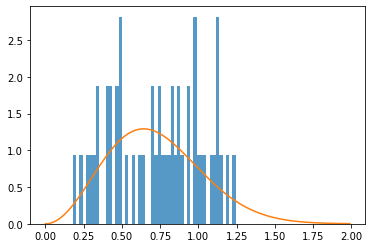

In [16]:
#velocity distribution

n = 50
time = 1
mass = 6.6464764e-27

r = np.arange(0,2,0.01)

out = plot_max(n,time,mass)
plt.plot(r,function_maxwell(r,a_cal(n,out,mass)));



## Studies:

### 1. Einstein's explanation of Brownian motion: 1 big red particle in the center, N smaller blue particles.

Brownian motion is the random motion of particles suspended in a fluid (a liquid or a gas) resulting from their collision with the fast-moving molecules in the fluid.

Our Goal is to simulate this, so to do so we take 1 big particle and N smaller particles by doing so n smaller particles are actually the fluid and the 1 big particle is suspended in it.

We will run this for different scenarios with different mass difference of the particles.

Paying close attention to the motion of the big particle as well as the small particles will give us good look at brownian motion without getting into Statistical mechanics

##### Cases:
    
1. Big particle and small particle have the same radius but mass are different

2. Big particle and small particle have the same radius but mass difference is so big that the mass of small particle is close to being insignificant

3. again but with the big particle at rest at the center of the square

In [17]:
def brownian(n,time,mass1,mass2,radius2,veloctiy,tick = True):
    """
    The function simulates brownian motion and plots the particles path
    
    Args:
        n:        number of particles
        time:     time duration for simulation
        mass1:    mass of the bigger red particle
        mass2:    mass of smaller blue partiles
        radius2:  radius of the smaller particles
        velocity: velocity of the red particles
        tick:     ticks for the graph
    
    
    """
    
    v      = veloctiy
    vx,vy  = v[0],v[1]
    parlst = [Particle(0.05,0.05,vx,vy,Mass = mass1)]

    
    mass = mass2

    #random particles are set
    for i in range(n):
        parlst.append(Particle(random.random()/10,random.random()/10,((random.random()*2)-1)/10,((random.random()*2)-1)/10,radius = radius2,Mass = mass))



    sim = Simulation(parlst,L=1/10)
    simu_output = sim.do_simulate(time)



    for j in range(n+1):
        output_1_x=[i[j][0][0] for i in simu_output]
        output_1_y=[i[j][0][1] for i in simu_output]

        min_len = min(len(output_1_x),len(output_1_y))
        if(j == 0):
            plt.plot(output_1_y[:min_len],output_1_x[:min_len],'ro');
        else:
            plt.plot(output_1_y[:min_len],output_1_x[:min_len],'b,');

    if(tick):
        plt.xticks([]);
        plt.yticks([]);
    

##### Case 1:

First i am running some edge cases for the given cases

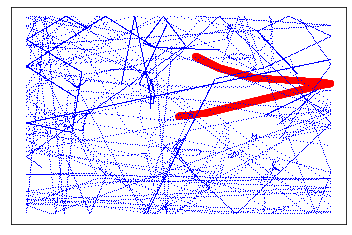

In [19]:
n            = 10
time         = 10
mass_red     = 1
mass_blue    = 1e-2
radius_blue  = 0.01 #the radius of the blue particle == radius of red but mass is same
velocity_red = [0.001,0.01]

brownian(n,time,mass_red,mass_blue,radius_blue,velocity_red)

###### Note:
As you can see the small particles that act as the medium have a pretty random motion. To explore this I will reduce the number of particles 

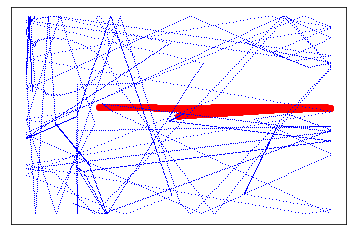

In [20]:
n1 = 5
brownian(n1,time,mass_red,mass_blue,radius_blue,velocity_red)

###### Note:
Now to see the interaction between the medium particles and the suspended particle I will set the big particle's velocity to zero

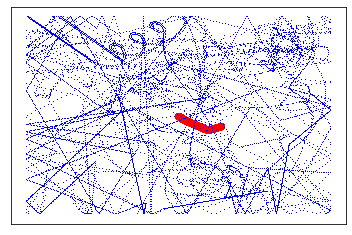

In [21]:
velocity_red_new = [0,0]
brownian(n,time,mass_red,mass_blue,radius_blue,velocity_red_new)

###### Note:
Now looking at another edge case, What if the radius of the medium particle is significantly bigger than the radius of red particle. I.e the red particle is a denser particle.

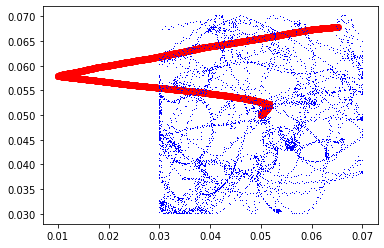

In [22]:
radius_blue_new  = 0.03
brownian(n1,time,mass_red,mass_blue,radius_blue_new,velocity_red_new,tick=False)

###### Note:
This makes the smaller particles to form a seperate group of their own. That can be seen as our box has a side length of 0.01 but the blue particles restrict themseleves to a specific part. I removed the ticks intially but had to keep them for this part

Now running the orignal case:

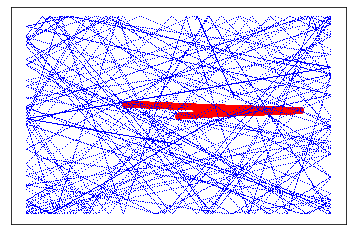

In [23]:
n            = 15
time         = 10
mass_red     = 1
mass_blue    = 1e-2
radius_blue  = 0.0001 #the radius is less
velocity_red = [0.001,0.01]

brownian(n,time,mass_red,mass_blue,radius_blue,velocity_red)

##### Case 2: Mass of blue particle <<<< Mass of red particle

Edge Cases:
1. radius are same
2. radius of blue particle is bigger
3. both the above cases but with red particle at rest 

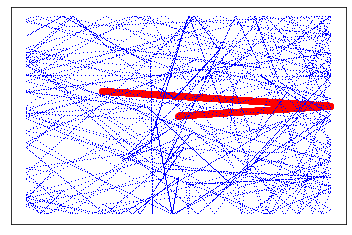

In [24]:
n2            = 10
time2         = 10
mass_red2     = 1
mass_blue2    = 1e-27
radius_blue2  = 0.01 #the radius of the blue particle == radius of red but mass is same
velocity_red2 = [0.001,0.01]

brownian(n2,time2,mass_red2,mass_blue2,radius_blue2,velocity_red2)

##### Note:
Now with the particle at rest

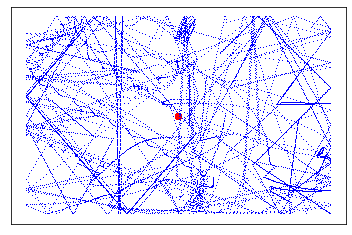

In [25]:
velocity_red2_new = [0,0]
brownian(n2,time2,mass_red2,mass_blue2,radius_blue2,velocity_red2_new)

##### Note:
Edge Case 2: Radius of blue particle is bigger

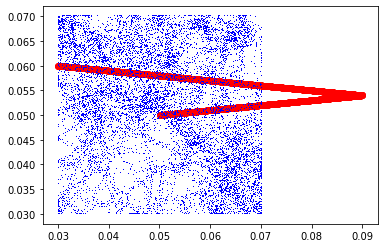

In [26]:
radius_blue2_new = 0.03
brownian(n2,time2,mass_red2,mass_blue2,radius_blue2_new,velocity_red2,tick=False)


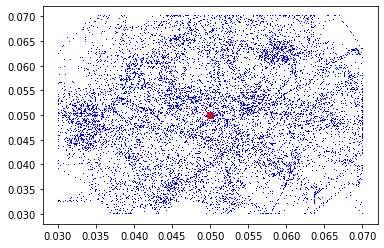

In [27]:
brownian(n2,time2,mass_red2,mass_blue2,radius_blue2_new,velocity_red2_new,tick=False)

##### Note:
General Case: radius blue < radius red


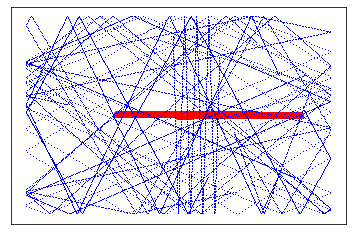

In [28]:
n2            = 10
time2         = 10
mass_red2     = 1
mass_blue2    = 1e-27
radius_blue2  = 0.0001 
velocity_red2 = [0.0001,0.01]

brownian(n2,time2,mass_red2,mass_blue2,radius_blue2,velocity_red2)

##### Note:
As the mass of the medium particles is so less the big particle is not effected by the collisons


##### General Brownian motion 

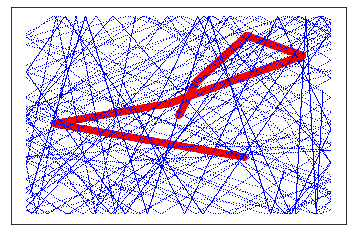

In [29]:
n2            = 15
time2         = 10
mass_red2     = 1
mass_blue2    = 1e-1
radius_blue2  = 0.001 
velocity_red2 = [0.0301,0.01]

brownian(n2,time2,mass_red2,mass_blue2,radius_blue2,velocity_red2)

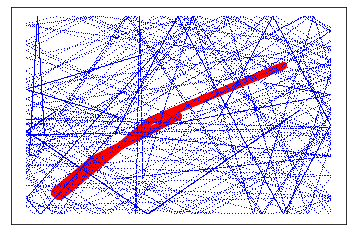

In [30]:
n2            = 15
time2         = 10
mass_red2     = 1
mass_blue2    = 1e-1
radius_blue2  = 0.001 
velocity_red2 = [0,0]

brownian(n2,time2,mass_red2,mass_blue2,radius_blue2,velocity_red2)

#### Conclusion to the Study:

Due to the large number of particles in a small box multiple collisions lead to the motion of the particle looking random in nature. Statistically this can be analyzed further  

### 2. Approach to equlilibrium

1. Mix two “gases” of different initial temperatures. Do they approach
constant temperature?


2. Mix two gases with different atomic masses. What happens to their temperatures and velocities?



##### Gases with different atomic masses:

In [31]:
def random_sim(n,time,mass1,mass2):
    """
    Runs a random simulation of n particles with random velocity and random positions
    
    
    Args:
    
        n:     number of particles of each mass
        time:  time for which the simulation has to be run
        mass1: mass of each particle of the 1st gas
        mass2: mass of each particle of the 2nd gas
    
    Return:
        The output of the simulation
    """
    parlst = []
        
        
        #random particles are set
    for i in range(n):
        parlst.append(Particle(random.random()/10,random.random()/10,((random.random()*2)-1)/10,((random.random()*2)-1)/10,Mass = mass1))
        parlst.append(Particle(random.random()/10,random.random()/10,((random.random()*2)-1)/10,((random.random()*2)-1)/10,Mass = mass2))


    sim = Simulation(parlst,L=.1)
    simu_output = sim.do_simulate(time)
    return simu_output
    
def temp_cal(n,time,mass1,mass2):
    """
    Calculates the value of temp and rms for every timestep
    
    Args:
    
        n:     number of particles
        time:  time for which the simulation has to be run
        mass1: mass of each particle of the 1st gas
        mass2: mass of each particle of the 2nd gas
        
    Return value of temp and rms
    
    """
    
    sim_output = random_sim(round(n/2),time,mass1,mass2)
    mass = (mass1+mass2)/2
    temp_ls = []
    rms_ls = []
    for j in range(len(sim_output)):
        #rms is calculated
        rms  = np.sqrt((np.sum([i[1][0]**2+ i[1][1]**2 for i in sim_output[j]])/(2*n)))
        rms1 = (np.sum([i[1][0]**2+ i[1][1]**2 for i in sim_output[j]])/(2*n))
        #temp is calculated
        if(j%2 == 0):
            temp = (rms1*mass1)/(3*1.38e-23)
        else:
            temp = (rms1*mass2)/(3*1.38e-23)

        rms_ls.append(rms)
        temp_ls.append(temp)
        
    return [[temp_ls],[rms_ls]]


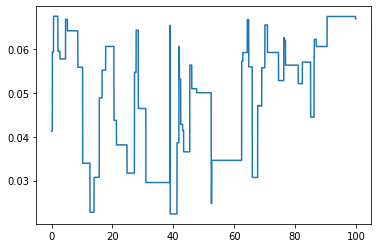

In [35]:
n = 2
time = 100
mass1 = 1e-19
mass2 = 1e-20
output_ = temp_cal(n,time,mass1,mass2)
temp,rms = output_[0][0],output_[1][0]
time_range = np.arange(0,time,0.01)

plt.plot(time_range,rms);




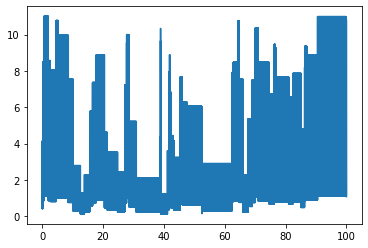

In [36]:
plt.plot(time_range,temp);

#### Note:

When we take two gasses of different atomic mass they after some time both the velocity and the temperature converge to a single value that is different from the one intially. It converges to a constant temperature

#### Gasses with different intial temperature:

In [37]:
def random_sim_different(n,time,mass):
    """
    Runs a random simulation of n particles with random velocity and random positions
    
    
    Args:
    
        n:     number of particles of each mass
        time:  time for which the simulation has to be run
        mass1: mass of each particle of the 1st gas
        mass2: mass of each particle of the 2nd gas
    
    Return:
        The output of the simulation
    """
    parlst1 = []
    parlst2 = []
    parslet = []
    
        
        
        #random particles are set
    for i in range(n):
        parlst1.append(Particle(random.random()/10,random.random()/10,((random.random()*2)-1)/10,((random.random()*2)-1)/10,Mass = mass))
        parlst2.append(Particle(random.random()/10,random.random()/10,((random.random()*2)-1)/10,((random.random()*2)-1)/10,Mass = mass))
    
    sim1 = Simulation(parlst1,L=.1)
    simu_output1 = sim1.do_simulate(time)
    temp1 = temp_c(n,simu_output1,time,mass)[-1]
    for i in range(len(simu_output1[-1])):
        parslet.append(Particle(simu_output1[-1][i][0][0],simu_output1[-1][i][0][1],simu_output1[-1][i][1][0],simu_output1[-1][i][1][1]))
    
    sim2 = Simulation(parlst2,L=.1)
    simu_output2 = sim2.do_simulate(time)
    temp2 = temp_c(n,simu_output2,time,mass)[-1]
    for i in range(len(simu_output1[-1])):
        parslet.append(Particle(simu_output2[-1][i][0][0],simu_output2[-1][i][0][1],simu_output2[-1][i][1][0],simu_output2[-1][i][1][1]))
    
    
    sim = Simulation(parslet,L=.1)
    simu_output = sim.do_simulate(time)
    print("Temp of 1st system: "+str(temp1)+" Temp of 2nd system: "+str(temp2))
    return simu_output
    
def temp_c(n,sim,time,mass):
    """
    Calculates the value of temp and rms for every timestep
    
    Args:
    
        n:     number of particles
        sim:   simulation
        time:  time for which the simulation has to be run
        mass1: mass of each particle of the 1st gas
        mass2: mass of each particle of the 2nd gas
        
    Return value of temp and rms
    
    """
    
    sim_output = sim
    temp_ls = []
    rms_ls = []
    for j in range(len(sim_output)):
        #rms is calculated
        rms  = np.sqrt((np.sum([i[1][0]**2+ i[1][1]**2 for i in sim_output[j]])/(2*n)))
        rms1 = (np.sum([i[1][0]**2+ i[1][1]**2 for i in sim_output[j]])/(2*n))
        
        temp = (rms1*mass1)/(3*1.38e-23)
    
        rms_ls.append(rms)
        temp_ls.append(temp)
        
    return temp_ls



Temp of 1st system: 12.657042017372364 Temp of 2nd system: 8.483946640998155
Temp of final system: 10.570494329185244


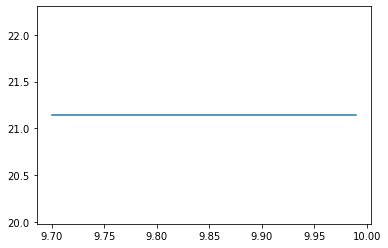

In [38]:
n = 2
time = 10
mass = 1e-20
output_temp = random_sim_different(n,time,mass)
temp        = temp_c(n,output_temp,time,mass)[-30:]
print("Temp of final system: "+str(temp[-1]/2))
time_range  = np.arange(0,time,0.01)[-30:]

plt.plot(time_range,temp);

#### Note:

As the mass of the particles is the same the final system reaches a temperature that is the average of the two temperature

#### Conclusion of the study:

Each system which is in equilibrium when mixed with another system in equilibrium. The new system tries to reach equilibrium.

The velocities and the temperature of the new system fluctuate intially and then it becomes constant after a while



## Discussion:

#### 1. Efficiency

Our Codes are not that efficient and the worst case run time is $O(N*(T/dt))$ where N is the number of particles T is the total time for which the simulation has to be ran and dt is the time step at which each particle is advanced.

How can the efficiency of the code be improved?

One way to improve the efficiency would be to use a divide and conquer algorithm called space partitioning where each space is divided into several regions, and then the same space-partitioning algorithm is recursively applied to each of the regions. An example would be:

1. Split the box in half

2. Check if there are particles more than 2 particles in the region

3. If Step 2 is False then go to the other half

4. If Step 2 is True then split the region in half and Repeat Step 1

5. Once there are exactly 2 particles check if they collide

This is a pretty efficent algorithm with the average run time of $O(log(N)*(T/dt))$

#### 2. Learning

There were a lot of thermodynamic concepts I had to learn while attempting to code this as the third test required us to test about equilibrium.

This was also the first time I was using natural units.

##### 3. Limitations of numerical methods

1. There is no form of generalizations

2. Motion of atomic particles aren't time reversable

### Conclusions: 

It was seen that atomic collisions in a box is the same as an ideal gas. Adding intramolecular forces can help us simulate a real gas using the same model. Laws of thermodynamics were also true for each situationa and momentum and energy was conserved for each collision.

## Thank you

## The End